In [1]:
import os
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local').getOrCreate()

dataSample = spark.read.options(
    header='True',
    inferSchema='True',
    delimiter=',',
).csv(os.path.expanduser('~/data/DataSample.csv'))

POISample = spark.read.options(
    header='True',
    inferSchema='True',
    delimiter=',',
).csv(os.path.expanduser('~/data/POIList.csv'))

21/09/28 23:34:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
dataSample = dataSample.withColumnRenamed(" TimeSt", "TimeSt")

## 1. Cleanup

In [3]:
alias1 = dataSample.alias("a1")
alias2 = dataSample.alias("a2")
joinedDataSet = alias1.join(alias2, (alias1["a1.TimeSt"] == alias2["a2.TimeSt"]) & (alias1["a1.Latitude"] == alias2["a2.Latitude"]) & (alias1["a1.Longitude"] == alias2["a2.Longitude"]) & (alias1["a1._ID"] != alias2["a2._ID"]))
joinedDataSet.persist()

joinedDataSet = joinedDataSet.select("a1._ID", "a1.TimeST", "a1.Country", "a1.Province", "a1.City", "a1.Latitude", "a1.Longitude")

cleanDataSample = dataSample.subtract(joinedDataSet)
cleanDataSample.persist()
joinedDataSet.unpersist()
cleanDataSample.show()


+-------+--------------------+-------+--------+---------------+--------+----------+
|    _ID|              TimeSt|Country|Province|           City|Latitude| Longitude|
+-------+--------------------+-------+--------+---------------+--------+----------+
|5279891|2017-06-21 15:54:...|     CA|      AB|       Edmonton| 53.5515|  -113.492|
|5477591|2017-06-21 18:11:...|     CA|      ON|    Scarborough| 43.7658|   -79.185|
|5516699|2017-06-21 11:14:...|     CA|      NB|        Moncton| 46.1183|  -64.7338|
|4978301|2017-06-21 03:32:...|     CA|      ON|         Ottawa| 45.4236|  -75.6272|
|5340923|2017-06-21 04:58:...|     CA|      BC|      Vancouver| 49.2654|  -123.194|
|5471089|2017-06-21 02:10:...|     CA|      AB|  Fort Mcmurray| 56.7377|  -111.438|
|5402315|2017-06-21 04:03:...|     CA|      ON|    Mississauga| 43.5872|   -79.643|
|5507624|2017-06-21 06:13:...|     CA|      ON|        Toronto| 43.6735|   -79.403|
|5310242|2017-06-21 10:55:...|     CA|      AB|       Edmonton|53.44669|-113

# 2. Label

In [4]:

def distance(lat, lon, lat2, lon2):
    return (((lat-(lat2))**2 + (lon-(lon2))**2)**(1/2))
            
            

In [5]:

alias1 = cleanDataSample.alias("a1")
alias2 = POISample.alias("a2")
joined = alias1.join(alias2)

joined.persist()

joined = joined.withColumn("Distance", distance(alias1["a1.Latitude"], alias1["a1.Longitude"], alias2["a2.Latitude"], alias2["a2.Longitude"]))
joined.createOrReplaceTempView("data")
joined = spark.sql("Select jID, Min as Distance, POIID from data, (SELECT _ID as jID, min(Distance) as Min from data group by _ID) where min = distance and _ID = jID")

joined = joined.dropDuplicates(["jID"])



cleanDataSample = cleanDataSample.join(joined, cleanDataSample._ID == joined.jID ).drop("jID")
joined.unpersist()

cleanDataSample.show()
    

+-------+--------------------+-------+--------+----------------+--------+---------+-------------------+-----+
|    _ID|              TimeSt|Country|Province|            City|Latitude|Longitude|           Distance|POIID|
+-------+--------------------+-------+--------+----------------+--------+---------+-------------------+-----+
|4517905|2017-06-21 17:00:...|     CA|      ON|         Windsor| 42.2957| -82.9599|   9.93234736688247| POI3|
|4526426|2017-06-21 17:00:...|     CA|      QC|   Saint-Nicolas|46.72072|-71.30409|  2.560110280170952| POI3|
|4535091|2017-06-21 11:00:...|     CA|      AB|         Calgary|  51.049|-113.9622| 2.5422161346048036| POI1|
|4545807|2017-06-21 04:01:...|     CA|      ON|         Markham|43.85883|-79.29809|  5.968373408455358| POI3|
|4559622|2017-06-21 18:01:...|     CA|      ON|        Kingston| 44.2647| -76.5504| 3.2382666073714477| POI3|
|4566292|2017-06-21 03:01:...|     CA|      ON|     Mississauga|  43.603| -79.5938|  6.325758511500184| POI3|
|4627121|2

# 3. Analysis

In [6]:
cleanDataSample.createOrReplaceTempView("data")

POIData = spark.sql("SELECT POIID, avg(distance) as avg, stddev(distance) stddev, max(distance) as max, count(*) as count  from data group by poiid")
POIData.persist()
POIData.show()

+-----+------------------+------------------+------------------+-----+
|POIID|               avg|            stddev|               max|count|
+-----+------------------+------------------+------------------+-----+
| POI4| 8.522389808711127| 27.33458316385115| 192.7049913074258|  427|
| POI1| 3.353111768940218|3.8496400815971277|24.851937229893878| 8725|
| POI3|5.5379191396554655|2.8587108750939807|20.155377791591437| 8821|
+-----+------------------+------------------+------------------+-----+



In [7]:
lats = []
lons = []
dists = []
counts = []
names = []


for x in POISample.toLocalIterator():
    lats.append(x["Latitude"])
    lons.append(x["Longitude"])
    names.append(x["POIID"])
    
    POIDataInfo = POIData.filter(POIData["POIID"] == x["POIID"]).collect()
    if len(POIDataInfo) != 0:
        dists.append(POIDataInfo[0]["max"])
        counts.append(POIDataInfo[0]["count"])
    else:
        dists.append(0)
        counts.append(0)


In [8]:
cleanDataSample.unpersist()


%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.image as mpimg




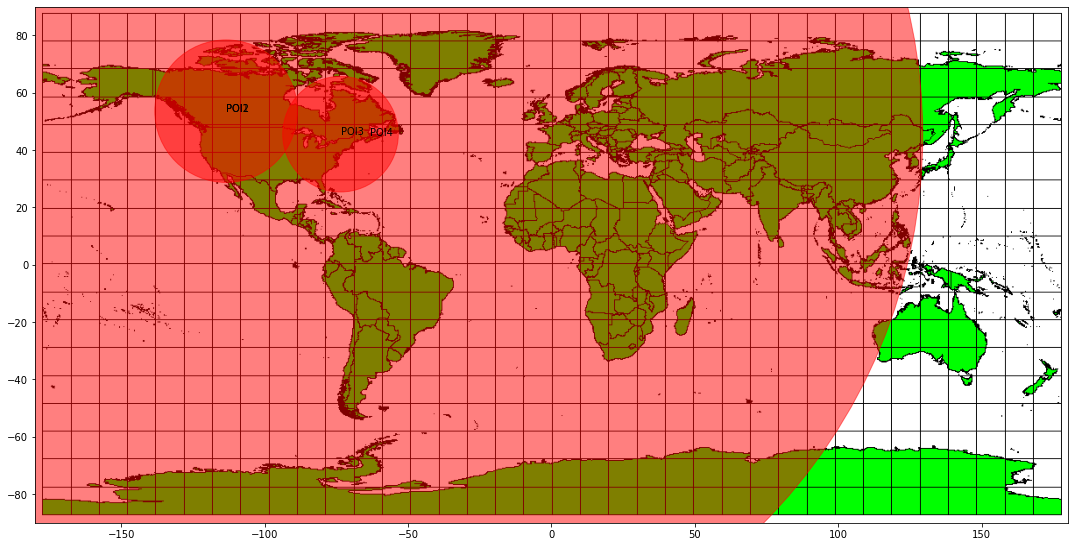

In [9]:

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)


#ax.scatter(x = lons, y=lats, s=dists, alpha=0.50, c='r')
for i, txt in enumerate(names):
    ax.annotate(txt, (lons[i], lats[i]))


for i in range(0, len(lats)):
    circle1 = plt.Circle((lons[i], lats[i]), dists[i], color='r', alpha=0.50)
    ax.add_patch(circle1)

map_img=mpimg.imread(os.path.expanduser('~/data/World-Map.png'))


ax.imshow(map_img, extent=[-180, 180, -90, 90])


In [10]:
import math
POIData = POIData.withColumn("Radius", POIData["max"])
POIData = POIData.withColumn("Density", POIData["count"]/((POIData["max"]**2)*math.pi))
POIData.show()

+-----+------------------+------------------+------------------+-----+------------------+-------------------+
|POIID|               avg|            stddev|               max|count|            Radius|            Density|
+-----+------------------+------------------+------------------+-----+------------------+-------------------+
| POI4| 8.522389808711127| 27.33458316385115| 192.7049913074258|  427| 192.7049913074258|0.00366009261696348|
| POI1| 3.353111768940218|3.8496400815971277|24.851937229893878| 8725|24.851937229893878|  4.496711933878291|
| POI3|5.5379191396554655|2.8587108750939807|20.155377791591437| 8821|20.155377791591437|  6.911718842827215|
+-----+------------------+------------------+------------------+-----+------------------+-------------------+



# 4a. Model

In [11]:
# I will let the raw score of each point be the 3*density/max(density) + 2*avg/max(avg) + max/max(max)
# This will make density the most important factor of the popularity, which makes sense, but POI's in which recieve requests 
# from a large area could also be considered popular, so the average distance and the max distance of requests are also included

densityMult = 4

avgDistanceMult = 2
distanceMult = 1


maxDensity = POIData.agg({"Density": "max"}).collect()[0]["max(Density)"] 
maxDistance = POIData.agg({"max": "max"}).collect()[0]["max(max)"]
maxAvgDistance = POIData.agg({"avg": "max"}).collect()[0]["max(avg)"]

POIData = POIData.withColumn("RawScore", POIData["Density"]*densityMult/maxDensity + POIData["max"]*distanceMult/maxDistance + POIData["avg"]*avgDistanceMult/maxAvgDistance)
POIData.show()

+-----+------------------+------------------+------------------+-----+------------------+-------------------+------------------+
|POIID|               avg|            stddev|               max|count|            Radius|            Density|          RawScore|
+-----+------------------+------------------+------------------+-----+------------------+-------------------+------------------+
| POI4| 8.522389808711127| 27.33458316385115| 192.7049913074258|  427| 192.7049913074258|0.00366009261696348| 3.002118195314476|
| POI1| 3.353111768940218|3.8496400815971277|24.851937229893878| 8725|24.851937229893878|  4.496711933878291|3.5182280663989047|
| POI3|5.5379191396554655|2.8587108750939807|20.155377791591437| 8821|20.155377791591437|  6.911718842827215| 5.404208366513039|
+-----+------------------+------------------+------------------+-----+------------------+-------------------+------------------+



In [12]:
# I will then use these values to compute any outliers, and then rank accordingly
from pyspark.sql.functions import udf
from pyspark.sql.functions import when
from pyspark.sql.functions import lit

quantiles = POIData.approxQuantile("RawScore", [0.25, 0.5, 0.75], 0.001)

maximumNonOutlier = POIData.filter(POIData['RawScore'] < quantiles[1] + 1.5*(quantiles[2]-quantiles[0])).agg({"RawScore": "max"}).collect()[0]["max(RawScore)"]
minNonOutlier = POIData.filter(POIData['RawScore'] > quantiles[1] - 1.5*(quantiles[2]-quantiles[0])).agg({"RawScore": "min"}).collect()[0]["min(RawScore)"]

POIData.drop("Score")
POIData = POIData.withColumn("max", lit(maximumNonOutlier))
POIData = POIData.withColumn("med", lit(quantiles[1]))
POIData = POIData.withColumn("min", lit(minNonOutlier))

@udf("float")
def giveScore(maximum, value, med, minimum):
    if(value <= minimum):
        return value-value - 10
    if(value >= maximum):
        return value-value + 10
    
    if(value > med):
        print(value)
        print(med)
        
        for i in range(0, 10):
            print(((maximum-med)/11)*(i+1))
            if(value < med + ((maximum-med)/11)*(i+1)):
                return value - value + i
    else:
        for i in range(0, 10):
            if(value > med - (med/11)*(i+1)):
                return value - value - i
        


POIData = POIData.withColumn("Score", giveScore(POIData.max, POIData.RawScore, POIData.med, POIData.min)).drop("max", "med", "min")


In [13]:
POIData.show()

+-----+------------------+------------------+-----+------------------+-------------------+------------------+-----+
|POIID|               avg|            stddev|count|            Radius|            Density|          RawScore|Score|
+-----+------------------+------------------+-----+------------------+-------------------+------------------+-----+
| POI4| 8.522389808711127| 27.33458316385115|  427| 192.7049913074258|0.00366009261696348| 3.002118195314476|-10.0|
| POI1| 3.353111768940218|3.8496400815971277| 8725|24.851937229893878|  4.496711933878291|3.5182280663989047|  0.0|
| POI3|5.5379191396554655|2.8587108750939807| 8821|20.155377791591437|  6.911718842827215| 5.404208366513039| 10.0|
+-----+------------------+------------------+-----+------------------+-------------------+------------------+-----+



# 4b. Pipeline Dependency

In [14]:
file = open(os.path.expanduser('~/data/task_ids.txt'), "r")
taskNames = file.read().split(",")
file.close()
paths = {}
starting = []

for task in taskNames:
    paths[task] = []

file = open(os.path.expanduser('~/data/relations.txt'), "r")

line = file.readline()

while line != "":
    dep = line.split("->")
    paths[dep[1].strip()].append(dep[0])
    line = file.readline()

file.close()

file = open(os.path.expanduser('~/data/question.txt'), "r")

starting = file.readline().split()
if len(starting) > 2:
    starting = starting[len(starting)-1].split(",")
else:
    starting = []
    
temp = file.readline().split()
end = temp[len(temp) - 1]

alreadyCompleted = []

prevSize = len(alreadyCompleted)

for x in starting:
    for y in paths[x]:
        alreadyCompleted.append(y)

while not prevSize == len(alreadyCompleted):
    prevSize = len(alreadyCompleted)
    toAdd = []
    for x in alreadyCompleted:
        for y in paths[x]:
            toAdd.append(y)
    for x in toAdd:
        if x not in alreadyCompleted:
            alreadyCompleted.append(x)


prevSize = 0
toComplete = [end]

counter = 0
while counter < len(toComplete):
    for y in paths[toComplete[counter]]:
        if y not in alreadyCompleted:
            while 1:
                index = -1
                try:
                    index = toComplete.index(y)
                except:
                    break
                del toComplete[index]   
            toComplete.append(y)
    counter+= 1
    
reordered = []

while len(toComplete) != 0:
    reordered.append(toComplete[-1])
    del toComplete[-1]

print(reordered)

['41', '39', '73', '21', '100', '20', '94', '112', '56', '97', '102', '36']
